# CSC 522 Project 
_by Team 21: Raphael Phillips (rjphill4), Sogolsadat Mansouri (smansou2), Rithik Jain (rjain25), and Neeloy Gomes (ntgomes)_

This project will involve developing a machine learning model using supervised learning to predict future exchange rates for a specific currency pair, based on historical exchange rate data and other relevant features.


In [72]:
# Run the python files needed for setting global variables/functions/classes for the notebook

%run pre_processing.py
%run lstm_rnn.py
%run rand_network_ensemble.py

In [80]:
# Import necessary libraries for the notebook

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

In [74]:
# Instantiate and clean the two input datasets

usdinr_df = pd.read_csv('../data/USDINRX.csv')
forex_df = pd.read_csv('../data/forex.csv')

print('Instantiated the input CSVs as dataframes')

cleaned_usdinr_df = pre_p_usdinr(usdinr_df)
cleaned_forex_df = pre_p_forex(forex_df)

print('Cleaned ' + str(len(forex_df.index) - len(cleaned_forex_df.index)) + ' rows from data/forex.csv')
print('Cleaned ' + str(len(usdinr_df.index) - len(cleaned_usdinr_df.index)) + ' rows from data/USDINRX.csv')

Instantiated the input CSVs as dataframes
Cleaned 1448456 rows from data/forex.csv
Cleaned 52 rows from data/USDINRX.csv


In [75]:
# Merge the two input datasets

merged_df = merge(cleaned_forex_df, cleaned_usdinr_df)
print('Merged the two datasets')
merged_df

Merged the two datasets


,date,open,high,low,close
0,12387,45.709000,45.728001,45.615002,45.709999
1,12388,45.709000,45.719002,45.560001,45.629002
2,12389,45.632000,45.655998,45.474998,45.549999
3,12390,45.548000,45.612999,45.519001,45.548000
4,12391,45.549999,45.566002,45.449001,45.449001
...,...,...,...,...,...
9172,18890,73.696198,73.899597,73.607002,73.696098
9173,18891,73.659302,73.790100,73.549004,73.658997
9174,18892,73.795097,73.941498,73.650002,73.792702
9175,18893,73.875000,73.925797,73.588997,73.874901


In [76]:
# Do the train test split on the merged dataset (50/50 due to limitations of the LSTM RNN)

merged_x_train, merged_x_test, merged_y_train, merged_y_test = split(merged_df)
print('Merged and did the train/test split of the datasets')

Merged and did the train/test split of the datasets


In [77]:
# Normalize the training and testing datasets for the processes of the LSTM RNN ensemble

x_train_scaler = MinMaxScaler()
x_train = pd.DataFrame(x_train_scaler.fit_transform(merged_x_train))

y_train_scaler = MinMaxScaler()
y_train = pd.DataFrame(y_train_scaler.fit_transform(merged_y_train.to_numpy().reshape(-1, 1)))

x_test_scaler = MinMaxScaler()
x_test = pd.DataFrame(x_test_scaler.fit_transform(merged_x_test))

y_test_scaler = MinMaxScaler()
y_test = pd.DataFrame(y_test_scaler.fit_transform(merged_y_test.to_numpy().reshape(-1, 1)))


In [78]:
# Instantiate and run the ensemble of random LSTM RNNs

lstm_args = { 
    "input_shape": (len(x_train.to_numpy()), len(x_train.to_numpy()[0])), 
    "lstm_units": 32, 
    "dense_units": 16, 
    "output_shape": (1,) 
}
ensembler = RandomNetworkEnsemble(num_networks = 10, base_nn_model = CustomLSTM, model_args = lstm_args, random_seed = 522)

ensembler.train(x_train.to_numpy(), y_train.to_numpy())
predicted_target = ensembler.predict(x_test.to_numpy())

Epoch 1/10
Epoch 1/10
1/1 [==============================] - 8s 8s/step - loss: 0.3700
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.3110
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.2758
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.2497
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.2285
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.2091
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.1908
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.1714
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.1525
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.1316
Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 0.3844
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.3230
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.277

In [83]:
y_test.to_numpy()

array([0.03383789, 0.04302369, 0.05603385, ..., 0.45246968, 0.44992083,
       0.44877276], dtype=float32)

In [86]:
# Printing some stats from the predictions

print('RMSE of tuned model\'s predictions: ' + str(ensembler.calculate_rmse_of_predicted(y_test.to_numpy())))

RMSE of tuned model's predictions: 0.2997939237691137


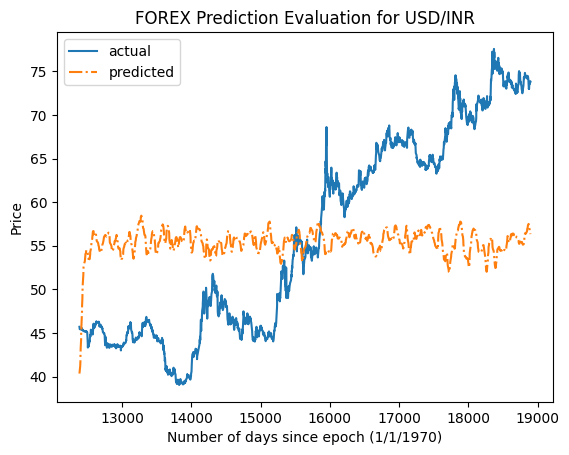

In [85]:
# Making a line chart of the predicted versus the actual
#   (inverse normalizing to adhere to the context)

plt.plot(merged_x_test.sort_values(by=['date'])['date'], pd.concat([merged_x_test, merged_y_test], axis = 1).sort_values(by=['date'])['close'], label ='actual')
plt.plot(merged_x_test.sort_values(by=['date'])['date'], y_test_scaler.inverse_transform(predicted_target.reshape(-1, 1)).ravel(), '-.', label ='predicted')

plt.xlabel('Number of days since epoch (1/1/1970)')
plt.ylabel('Price')
plt.legend()
plt.title('FOREX Prediction Evaluation for USD/INR')
plt.show()